In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import helper
from helper import *

In [74]:
df = load_and_preprocess()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.groupby(df.datetime.dt.date).agg('mean')
df.head()

,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
datetime,,,,,,,,,,,,,,
2012-10-01,75.727273,963.920433,285.887980,235.727273,3.272727,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.272727
2012-10-02,50.287179,1014.996834,286.937931,260.583333,1.666667,0.125000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.375000
2012-10-03,78.752564,1015.283302,287.374583,227.583333,1.333333,0.125000,0.000000,0.083333,0.0,0.0,0.0,0.125,0.0,0.666667
2012-10-04,83.305769,1017.194770,286.860833,101.583333,1.000000,0.083333,0.000000,0.208333,0.0,0.0,0.0,0.250,0.0,1.083333
2012-10-05,79.258333,1017.688516,287.535208,66.333333,1.708333,0.333333,0.083333,0.500000,0.0,0.0,0.0,0.000,0.0,2.083333


In [75]:
df = df.dropna()

In [76]:
df2 = df[['Temperature']].reset_index().rename(columns = {'datetime': 'Date'})
df2['Date'] = pd.to_datetime(df2['Date'])

In [77]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df2['Date'], y=df2['Temperature'], name='Temperature (Kelvin)'))
fig.update_layout(showlegend=True)
fig.show()

In [78]:
train, test = df2.loc[df2['Date'] <= '2016-01-01'], df2.loc[df2['Date'] > '2016-01-01']
train.shape, test.shape

((1188, 2), (699, 2))

In [79]:
sc = StandardScaler()
train['Temperature'] = sc.fit_transform(train[['Temperature']])
test['Temperature'] = sc.transform(test[['Temperature']])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
train

,Date,Temperature
0,2012-10-01,0.516831
1,2012-10-02,0.606133
2,2012-10-03,0.643271
3,2012-10-04,0.599575
4,2012-10-05,0.656933
...,...,...
1183,2015-12-28,-1.195804
1184,2015-12-29,-1.351696
1185,2015-12-30,-1.201776
1186,2015-12-31,-0.819025


In [81]:
def create_sequences(X, y, time_steps = 24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [82]:
n_timestamp = 7

X_train, y_train = create_sequences(train[['Temperature']], train[['Temperature']], n_timestamp)
X_test, y_test = create_sequences(test[['Temperature']], test[['Temperature']], n_timestamp)

In [98]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(96, input_shape = X_train.shape[1:]))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(X_train.shape[1]))
model.add(keras.layers.LSTM(96, return_sequences = True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(X_train.shape[2])))

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 96)                37632     
_________________________________________________________________
dropout_12 (Dropout)         (None, 96)                0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 7, 96)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 7, 96)             74112     
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 96)             0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 7, 1)              97        
Total params: 111,841
Trainable params: 111,841
Non-trainable params: 0
________________________________________________

In [99]:
history = model.fit(X_train, y_train, epochs = 100, validation_split=0.1, batch_size = 32, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
34/34 [==============================] - 4s 30ms/step - loss: 0.5341 - val_loss: 0.3108
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 0.3850 - val_loss: 0.3136
Epoch 3/100
34/34 [==============================] - 0s 7ms/step - loss: 0.3476 - val_loss: 0.3093
Epoch 4/100
34/34 [==============================] - 0s 7ms/step - loss: 0.3487 - val_loss: 0.2986
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 0.3433 - val_loss: 0.2911
Epoch 6/100
34/34 [==============================] - 0s 7ms/step - loss: 0.3302 - val_loss: 0.2997
Epoch 7/100
34/34 [==============================] - 0s 9ms/step - loss: 0.3099 - val_loss: 0.2932
Epoch 8/100
34/34 [==============================] - 0s 9ms/step - loss: 0.3032 - val_loss: 0.2894
Epoch 9/100
34/34 [==============================] - 0s 8ms/step - loss: 0.3180 - val_loss: 0.2827
Epoch 10/100
34/34 [==============================] - 0s 7ms/step - loss: 0.2984 - val_loss: 0.2772
Epoch 11

In [100]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis = 1)

<AxesSubplot:ylabel='Count'>

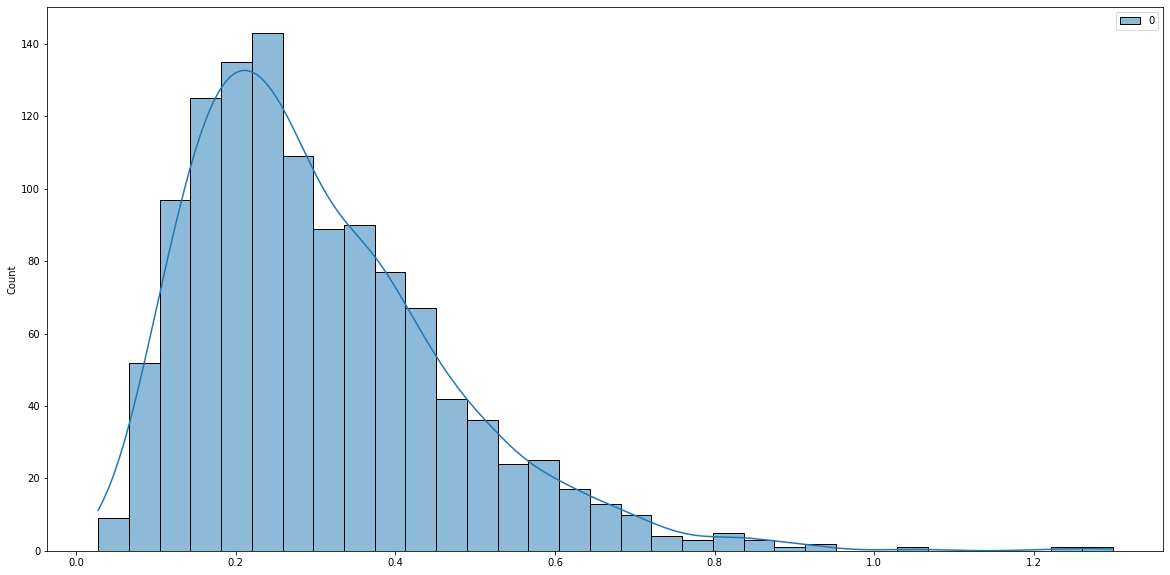

In [101]:
plt.figure(figsize=(20, 10))
sns.histplot(train_mae_loss, kde=True)

<AxesSubplot:ylabel='Count'>

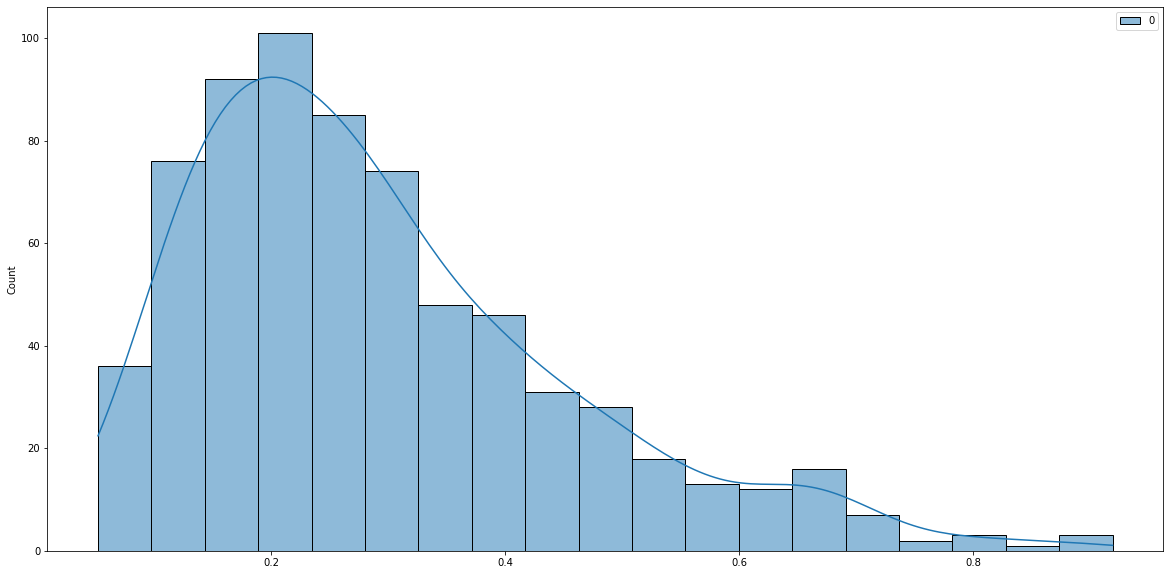

In [102]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)

plt.figure(figsize=(20,10))
sns.histplot(test_mae_loss, kde=True)

In [103]:
threshold = np.quantile(train_mae_loss, 0.98)

test_score_df = pd.DataFrame(test[n_timestamp:])
test_score_df['loss'] = test_mae_loss
test_score_df['anomaly'] = np.where(test_mae_loss>threshold, True, False)
test_score_df['threshold'] = threshold
test_score_df.head()

,Date,Temperature,loss,anomaly,threshold
1195,2016-01-09,-0.407197,0.425312,False,0.714314
1196,2016-01-10,-0.254526,0.690605,False,0.714314
1197,2016-01-11,-0.950797,0.690641,False,0.714314
1198,2016-01-12,-1.455965,0.434295,False,0.714314
1199,2016-01-13,-1.274304,0.464793,False,0.714314


In [104]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name = 'Test MAE'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [105]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(12, 5)

In [106]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=sc.inverse_transform(test_score_df['Temperature']) - 273.15, name = 'Temperature'))
fig.add_trace(go.Scatter(x = anomalies['Date'], y=sc.inverse_transform(anomalies['Temperature']) - 273.15, name = 'Anomaly', mode = 'markers'))
fig.update_layout(showlegend=True, title='Detected Anomalies')
fig.show()